In [ ]:
from typing import TypedDict, List, Dict, Any, Optional, Annotated
from langgraph.graph import StateGraph, END
from operator import add
from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Element, Text, Image, FigureCaption, Table, CompositeElement
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langchain_community.vectorstores import Chroma
import sqlite3
import base64
import json
import os
from datetime import datetime
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# State definition with proper annotations for parallel processing
class DocumentProcessingState(TypedDict):
    document_path: str
    raw_chunks: List[Any]
    text_chunks: List[Any]
    
    # Extracted content (using Annotated for parallel updates)
    images: Annotated[List[Dict[str, Any]], add]
    tables: Annotated[List[Dict[str, Any]], add] 
    text_data: Annotated[List[Dict[str, Any]], add]
    
    # Processed content with descriptions
    processed_images: Annotated[List[Dict[str, Any]], add]
    processed_tables: Annotated[List[Dict[str, Any]], add]
    processed_text: Annotated[List[Dict[str, Any]], add]
    
    # Storage status (using Annotated for parallel updates)
    storage_status: Annotated[List[str], add]
    
    # Overall status
    processing_status: str

# Initialize models and storage
def initialize_models():
    """Initialize the language model and storage systems"""
    model = ChatGroq(
        model_name="llama3-8b-8192", 
        groq_api_key="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"
    )
    
    # Initialize vector store with proper error handling
    try:
        from langchain_community.embeddings import HuggingFaceEmbeddings
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        
        vector_store = Chroma(
            collection_name="document_text",
            embedding_function=embeddings,
            persist_directory="./vectorstore_db"
        )
        print("✅ Vector store initialized successfully")
        
    except Exception as e:
        print(f"⚠️ Vector store initialization failed: {e}")
        print("📝 Will continue without vector storage...")
        vector_store = None
    
    # Initialize SQL database for tables
    try:
        conn = sqlite3.connect('tables.db')
        cursor = conn.cursor()
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS table_metadata (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                table_id TEXT UNIQUE,
                description TEXT,
                html_content TEXT,
                source_document TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        conn.commit()
        conn.close()
        print("✅ SQL database initialized successfully")
        
    except Exception as e:
        print(f"⚠️ SQL database initialization failed: {e}")
    
    return model, vector_store

# Node 1: Document Parsing
def parse_document_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Parse the PDF document and extract all elements"""
    
    print(f"📄 Parsing document: {state['document_path']}")
    
    try:
        # Extract all elements with images as payload
        raw_chunks = partition_pdf(
            filename=state["document_path"],
            strategy="hi_res",
            infer_table_structure=True,
            extract_image_block_types=["Image", "Figure", "Table"],
            extract_image_block_to_payload=True,
            chunking_strategy=None,
        )
        print(f"✅ Successfully parsed document with {len(raw_chunks)} elements")
        
        # Extract text chunks separately for better chunking
        text_chunks = partition_pdf(
            filename=state["document_path"],
            strategy="hi_res",
            chunking_strategy="by_title",
            max_characters=2000,
            combine_text_under_n_chars=500,
            new_after_n_chars=1500
        )
        print(f"✅ Successfully chunked text into {len(text_chunks)} chunks")
        
    except Exception as e:
        print(f"❌ Error during document parsing: {e}")
        raw_chunks = []
        text_chunks = []
    
    return {
        "raw_chunks": raw_chunks,
        "text_chunks": text_chunks,
        "processing_status": "parsed"
    }

# Node 2: Image Extraction
def extract_images_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Extract images and their captions from raw chunks"""
    
    print("🖼️ Extracting images...")
    
    all_images = []
    raw_chunks = state["raw_chunks"]
    
    for idx, chunk in enumerate(raw_chunks):
        if isinstance(chunk, Image):
            # Check if next chunk is a figure caption
            caption = None
            if idx + 1 < len(raw_chunks) and isinstance(raw_chunks[idx + 1], FigureCaption):
                caption = raw_chunks[idx + 1].text
            
            all_images.append({
                "index": idx,
                "caption": caption if caption else "No caption",
                "image_text": chunk.text,
                "base64_image": chunk.metadata.image_base64,
                "source_document": state["document_path"]
            })
    
    print(f"✅ Extracted {len(all_images)} images")
    
    return {"images": all_images}

# Node 3: Table Extraction
def extract_tables_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Extract tables from raw chunks"""
    
    print("📊 Extracting tables...")
    
    table_data = []
    raw_chunks = state["raw_chunks"]
    
    for idx, element in enumerate(raw_chunks):
        if isinstance(element, Table):
            table_data.append({
                "index": idx,
                "table_as_html": element.metadata.text_as_html,
                "table_text": element.text,
                "source_document": state["document_path"]
            })
    
    print(f"✅ Extracted {len(table_data)} tables")
    
    return {"tables": table_data}

# Node 4: Text Extraction
def extract_text_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Extract and organize text chunks"""
    
    print("📝 Extracting text chunks...")
    
    text_data = []
    text_chunks = state["text_chunks"]
    
    for idx, chunk in enumerate(text_chunks):
        if isinstance(chunk, CompositeElement):
            text_data.append({
                "index": idx,
                "text": chunk.text,
                "element_type": type(chunk).__name__,
                "source_document": state["document_path"]
            })
    
    print(f"✅ Extracted {len(text_data)} text chunks")
    
    return {"text_data": text_data}

# Node 5: Image Description
def describe_images_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Generate descriptions for all extracted images"""
    
    print("🔍 Generating image descriptions...")
    
    model, _ = initialize_models()
    processed_images = []
    
    for image_data in state["images"]:
        try:
            prompt = (
                f"Describe the image in detail. The caption is: {image_data['caption']}. "
                f"The image text is: {image_data['image_text']} "
                f"Directly analyze the image and provide a detailed description without any additional text."
            )
            
            response = model.invoke([HumanMessage(content=prompt)])
            
            processed_images.append({
                **image_data,
                "description": response.content,
                "processed_at": datetime.now().isoformat()
            })
            
        except Exception as e:
            print(f"Error processing image {image_data['index']}: {e}")
            processed_images.append({
                **image_data,
                "description": f"Error generating description: {str(e)}",
                "processed_at": datetime.now().isoformat()
            })
    
    print(f"✅ Generated descriptions for {len(processed_images)} images")
    
    return {"processed_images": processed_images}

# Node 6: Table Description
def describe_tables_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Generate descriptions for all extracted tables"""
    
    print("📈 Generating table descriptions...")
    
    model, _ = initialize_models()
    processed_tables = []
    
    for table_data in state["tables"]:
        try:
            prompt = (
                "Analyze the following table and provide a detailed description of its contents, "
                "including the structure, key data points, and any notable trends or insights. "
                f"Here is the table in HTML format: {table_data['table_as_html']} "
                "Directly analyze the table and provide a detailed description without any additional text."
            )
            
            response = model.invoke([HumanMessage(content=prompt)])
            
            processed_tables.append({
                **table_data,
                "description": response.content,
                "processed_at": datetime.now().isoformat()
            })
            
        except Exception as e:
            print(f"Error processing table {table_data['index']}: {e}")
            processed_tables.append({
                **table_data,
                "description": f"Error generating description: {str(e)}",
                "processed_at": datetime.now().isoformat()
            })
    
    print(f"✅ Generated descriptions for {len(processed_tables)} tables")
    
    return {"processed_tables": processed_tables}

# Node 7: Text Processing
def process_text_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Process text chunks and add metadata"""
    
    print("⚡ Processing text chunks...")
    
    processed_text = []
    
    for text_data in state["text_data"]:
        processed_text.append({
            **text_data,
            "word_count": len(text_data["text"].split()),
            "char_count": len(text_data["text"]),
            "processed_at": datetime.now().isoformat()
        })
    
    print(f"✅ Processed {len(processed_text)} text chunks")
    
    return {"processed_text": processed_text}

# Node 8: Store Images
def store_images_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Store images and their descriptions in appropriate storage"""
    
    print("💾 Storing images...")
    
    try:
        # Create images directory if it doesn't exist
        os.makedirs("./stored_images", exist_ok=True)
        
        # Store images as files and metadata as JSON
        for i, image_data in enumerate(state["processed_images"]):
            # Save base64 image to file
            image_binary = base64.b64decode(image_data["base64_image"])
            image_filename = f"image_{image_data['index']}_{i}.png"
            image_path = os.path.join("./stored_images", image_filename)
            
            with open(image_path, "wb") as f:
                f.write(image_binary)
            
            # Save metadata
            metadata = {
                "image_path": image_path,
                "caption": image_data["caption"],
                "description": image_data["description"],
                "source_document": image_data["source_document"],
                "processed_at": image_data["processed_at"]
            }
            
            metadata_filename = f"image_metadata_{image_data['index']}_{i}.json"
            metadata_path = os.path.join("./stored_images", metadata_filename)
            
            with open(metadata_path, "w") as f:
                json.dump(metadata, f, indent=2)
        
        storage_status = f"Images: Successfully stored {len(state['processed_images'])} images"
        
    except Exception as e:
        storage_status = f"Images: Error storing images - {str(e)}"
        print(f"❌ {storage_status}")
    
    print(f"✅ {storage_status}")
    
    return {"storage_status": [storage_status]}

# Node 9: Store Tables in SQL
def store_tables_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Store tables in SQL database"""
    
    print("🗄️ Storing tables in SQL database...")
    
    try:
        conn = sqlite3.connect('tables.db')
        cursor = conn.cursor()
        
        for table_data in state["processed_tables"]:
            table_id = f"table_{table_data['index']}_{hash(table_data['source_document'])}"
            
            # Insert or update table metadata
            cursor.execute('''
                INSERT OR REPLACE INTO table_metadata 
                (table_id, description, html_content, source_document)
                VALUES (?, ?, ?, ?)
            ''', (
                table_id,
                table_data["description"],
                table_data["table_as_html"],
                table_data["source_document"]
            ))
        
        conn.commit()
        conn.close()
        
        storage_status = f"Tables: Successfully stored {len(state['processed_tables'])} tables in SQL database"
        
    except Exception as e:
        storage_status = f"Tables: Error storing tables - {str(e)}"
        print(f"❌ {storage_status}")
    
    print(f"✅ {storage_status}")
    
    return {"storage_status": [storage_status]}

# Node 10: Store Text in Vector Database
def store_text_node(state: DocumentProcessingState) -> Dict[str, Any]:
    """Store text chunks in vector database"""
    
    print("🔍 Storing text in vector database...")
    
    try:
        _, vector_store = initialize_models()
        
        if vector_store is None:
            # Fallback: store as JSON files
            os.makedirs("./stored_text", exist_ok=True)
            
            for i, text_data in enumerate(state["processed_text"]):
                text_filename = f"text_chunk_{text_data['index']}_{i}.json"
                text_path = os.path.join("./stored_text", text_filename)
                
                with open(text_path, "w") as f:
                    json.dump(text_data, f, indent=2)
            
            storage_status = f"Text: Stored {len(state['processed_text'])} text chunks as JSON files (vector store unavailable)"
        else:
            # Prepare documents for vector storage
            texts = []
            metadatas = []
            
            for text_data in state["processed_text"]:
                texts.append(text_data["text"])
                metadatas.append({
                    "index": text_data["index"],
                    "element_type": text_data["element_type"],
                    "source_document": text_data["source_document"],
                    "word_count": text_data["word_count"],
                    "char_count": text_data["char_count"],
                    "processed_at": text_data["processed_at"]
                }) 
            
            # Add to vector store
            vector_store.add_texts(texts=texts, metadatas=metadatas)
            
            storage_status = f"Text: Successfully stored {len(texts)} text chunks in vector database"
        
    except Exception as e:
        storage_status = f"Text: Error storing text - {str(e)}"
        print(f"❌ {storage_status}")
    
    print(f"✅ {storage_status}")
    
    return {"storage_status": [storage_status]}

# Create the parallel processing workflow
def create_document_processing_workflow():
    """Create the complete document processing workflow with parallel processing"""
    
    workflow = StateGraph(DocumentProcessingState)
    
    # Add all nodes
    workflow.add_node("parse_document", parse_document_node)
    workflow.add_node("extract_images", extract_images_node)
    workflow.add_node("extract_tables", extract_tables_node)
    workflow.add_node("extract_text", extract_text_node)
    workflow.add_node("describe_images", describe_images_node)
    workflow.add_node("describe_tables", describe_tables_node)
    workflow.add_node("process_text", process_text_node)
    workflow.add_node("store_images", store_images_node)
    workflow.add_node("store_tables", store_tables_node)
    workflow.add_node("store_text", store_text_node)
    
    # Define the workflow exactly as you specified
    workflow.set_entry_point("parse_document")
    
    # Parallel extraction after parsing
    workflow.add_edge("parse_document", "extract_images")
    workflow.add_edge("parse_document", "extract_tables")
    workflow.add_edge("parse_document", "extract_text")
    
    # Description nodes
    workflow.add_edge("extract_images", "describe_images")
    workflow.add_edge("extract_tables", "describe_tables")
    workflow.add_edge("extract_text", "process_text")
    
    # Storage nodes
    workflow.add_edge("describe_images", "store_images")
    workflow.add_edge("describe_tables", "store_tables")
    workflow.add_edge("process_text", "store_text")
    
    # Final consolidation - all end at the same time
    workflow.add_edge("store_images", END)
    workflow.add_edge("store_tables", END)
    workflow.add_edge("store_text", END)
    
    return workflow.compile()

# Usage function
def process_document(document_path: str):
    """Process a document through the complete pipeline"""
    
    # Create workflow
    workflow = create_document_processing_workflow()
    
    # Initial state
    initial_state = {
        "document_path": document_path,
        "raw_chunks": [],
        "text_chunks": [],
        "images": [],
        "tables": [],
        "text_data": [],
        "processed_images": [],
        "processed_tables": [],
        "processed_text": [],
        "storage_status": [],
        "processing_status": "initialized"
    }
    
    # Run the workflow
    print("🚀 Starting document processing pipeline...")
    try:
        result = workflow.invoke(initial_state)
        print("\n✨ Document processing completed!")
        return result
    except Exception as e:
        print(f"❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to print summary
def print_summary(result):
    """Print a nice summary of the processing results"""
    if not result:
        return
    
    print(f"\n🎉 Final Status: {result['processing_status']}")
    
    # Count results
    total_images = len(result.get('processed_images', []))
    total_tables = len(result.get('processed_tables', []))
    total_text = len(result.get('processed_text', []))
    
    print(f"\n📊 Processing Summary:")
    print(f"   🖼️  Images processed: {total_images}")
    print(f"   📊 Tables processed: {total_tables}")
    print(f"   📝 Text chunks processed: {total_text}")
    
    # Show storage status
    if result.get('storage_status'):
        print(f"\n💾 Storage Results:")
        for status in result['storage_status']:
            print(f"   ✅ {status}")

# Example usage
if __name__ == "__main__":
    # Install required packages if needed
    print("📦 Checking dependencies...")
    try:
        print("✅ Dependencies ready")
    except ImportError as e:
        print(f"❌ Missing dependency: {e}")
        print("💡 Run: pip install sentence-transformers chromadb")
    
    # Process your document
    try:
        result = process_document("2312.10997v5 (1) (2).pdf")
        
        if result:
            print_summary(result)
        
    except Exception as e:
        print(f"❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()

📦 Checking dependencies...
✅ Dependencies ready
🚀 Starting document processing pipeline...
📄 Parsing document: 2312.10997v5 (1) (2).pdf
✅ Successfully parsed document with 616 elements
✅ Successfully chunked text into 79 chunks
🖼️ Extracting images...
✅ Extracted 6 images
📊 Extracting tables...
✅ Extracted 4 tables
📝 Extracting text chunks...
✅ Extracted 78 text chunks
🔍 Generating image descriptions...
📈 Generating table descriptions...
⚡ Processing text chunks...
✅ Processed 78 text chunks
✅ Vector store initialized successfully
✅ SQL database initialized successfully
✅ Vector store initialized successfully
✅ SQL database initialized successfully
✅ Generated descriptions for 4 tables
✅ Generated descriptions for 6 images
💾 Storing images...
🗄️ Storing tables in SQL database...
🔍 Storing text in vector database...
✅ Tables: Successfully stored 4 tables in SQL database
✅ Images: Successfully stored 6 images
✅ Vector store initialized successfully
✅ SQL database initialized successfully

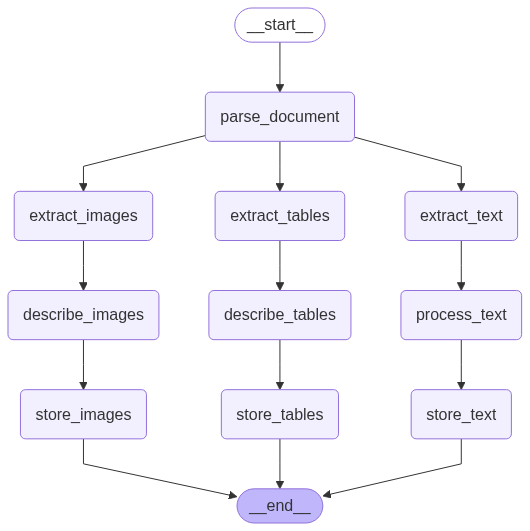

In [82]:
app=create_document_processing_workflow()

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    
    pass

In [83]:
import pandas as pd
from IPython.display import display, HTML, Image as IPImage
import base64
from io import BytesIO
import matplotlib.pyplot as plt

def display_stored_content():
    """Display all stored images, tables, and text content"""
    
    print("🎨 DISPLAYING STORED CONTENT")
    print("=" * 50)
    
    # Display Images
    display_stored_images()
    
    # Display Tables
    display_stored_tables()
    
    # Display Text
    display_stored_text()

def display_stored_images():
    """Display all stored images with their metadata and descriptions"""
    
    print("\n🖼️ STORED IMAGES")
    print("-" * 30)
    
    if not os.path.exists("./stored_images"):
        print("❌ No stored images found. Run the processing pipeline first.")
        return
    
    # Get all metadata files
    metadata_files = [f for f in os.listdir("./stored_images") if f.startswith("image_metadata")]
    
    if not metadata_files:
        print("❌ No image metadata found.")
        return
    
    for metadata_file in sorted(metadata_files):
        metadata_path = os.path.join("./stored_images", metadata_file)
        
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            
            print(f"\n📸 Image: {metadata_file}")
            print(f"   📍 Path: {metadata['image_path']}")
            print(f"   📝 Caption: {metadata['caption']}")
            print(f"   🤖 AI Description: {metadata['description'][:200]}...")
            print(f"   📅 Processed: {metadata['processed_at']}")
            
            # Display the actual image
            if os.path.exists(metadata['image_path']):
                try:
                    img = PILImage.open(metadata['image_path'])
                    plt.figure(figsize=(8, 6))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(f"Caption: {metadata['caption']}")
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"   ❌ Error displaying image: {e}")
            else:
                print(f"   ❌ Image file not found: {metadata['image_path']}")
                
        except Exception as e:
            print(f"❌ Error reading metadata {metadata_file}: {e}")

def display_stored_tables():
    """Display all stored tables from SQL database"""
    
    print("\n📊 STORED TABLES")
    print("-" * 30)
    
    try:
        conn = sqlite3.connect('tables.db')
        cursor = conn.cursor()
        
        # Get all tables
        cursor.execute("SELECT * FROM table_metadata ORDER BY created_at")
        tables = cursor.fetchall()
        
        if not tables:
            print("❌ No tables found in database.")
            conn.close()
            return
        
        for table in tables:
            table_id, description, html_content, source_doc, created_at = table[1], table[2], table[3], table[4], table[5]
            
            print(f"\n📋 Table ID: {table_id}")
            print(f"   📄 Source: {source_doc}")
            print(f"   🤖 AI Description: {description[:200]}...")
            print(f"   📅 Created: {created_at}")
            print(f"   📊 Table Content:")
            
            # Display the HTML table
            try:
                # Try to display as HTML if in Jupyter
                try:
                    display(HTML(html_content))
                except:
                    # Fallback: convert to pandas and display
                    df = pd.read_html(html_content)[0]
                    print(df.to_string(index=False))
                    
            except Exception as e:
                print(f"   ❌ Error displaying table: {e}")
                print(f"   📄 Raw HTML: {html_content[:200]}...")
        
        conn.close()
        
    except Exception as e:
        print(f"❌ Error accessing tables database: {e}")

def display_stored_text():
    """Display stored text content from vector database or JSON files"""
    
    print("\n📝 STORED TEXT")
    print("-" * 30)
    
    # Try vector database first
    try:
        _, vector_store = initialize_models()
        
        if vector_store is not None:
            # Try to get some sample documents from vector store
            try:
                # Get a sample query to show how retrieval works
                sample_docs = vector_store.similarity_search("", k=5)  # Get any 5 docs
                
                print(f"📚 Found {len(sample_docs)} text chunks in vector database")
                
                for i, doc in enumerate(sample_docs[:3]):  # Show first 3
                    print(f"\n📄 Text Chunk {i+1}:")
                    print(f"   📝 Content: {doc.page_content[:200]}...")
                    print(f"   📊 Metadata: {doc.metadata}")
                    
            except Exception as e:
                print(f"⚠️ Could not retrieve from vector store: {e}")
                
    except Exception as e:
        print(f"⚠️ Vector store not available: {e}")
    
    # Check JSON files as fallback
    if os.path.exists("./stored_text"):
        text_files = [f for f in os.listdir("./stored_text") if f.endswith('.json')]
        
        if text_files:
            print(f"\n📁 Found {len(text_files)} text files in JSON storage")
            
            for i, text_file in enumerate(sorted(text_files)[:5]):  # Show first 5
                text_path = os.path.join("./stored_text", text_file)
                
                try:
                    with open(text_path, 'r') as f:
                        text_data = json.load(f)
                    
                    print(f"\n📄 {text_file}:")
                    print(f"   📝 Content: {text_data['text'][:200]}...")
                    print(f"   📊 Type: {text_data['element_type']}")
                    print(f"   📈 Word Count: {text_data['word_count']}")
                    print(f"   📅 Processed: {text_data['processed_at']}")
                    
                except Exception as e:
                    print(f"❌ Error reading {text_file}: {e}")
        else:
            print("❌ No text files found in JSON storage.")
    else:
        print("❌ No stored text directory found.")